## 🎯 **Project Goal & Agenda**

**Goal**

Build an AI-powered Policy Drift Detection System that automatically:

* Extracts clause-level snippets from policy documents.

* Generates semantic embeddings for each snippet.

* Compares old vs. new clauses to detect changes, contradictions, or drift.

* Uses AI.GENERATE in BigQuery to classify the type of change, provide a short summary, and recommend a unified clause.

* Assigns a confidence score for every recommendation.

* Routes AI outputs through a human-in-the-loop review step.

* Inserts approved recommendations into a canonical Knowledge Base (KB) for authoritative reference.


**Agenda**

* Step 1 – Dataset Setup: Create BigQuery datasets & external object tables linked to Cloud Storage.

* Step 2 – Clause Extraction: Use AI.GENERATE to extract structured clause snippets from documents.

* Step 3 – Embeddings & Vector Search: Generate embeddings with ML.GENERATE_EMBEDDING and enable semantic search.

* Step 4 – Candidate Pairing: Identify similar/changed snippets using distance metrics.

* Step 5 – AI Comparison: Run AI.GENERATE with a strict JSON schema to classify change type, summarize differences, and suggest a unified clause.

* Step 6 – Human Review: Reviewer approves/rejects AI suggestions (simulated with SQL filters).

* Step 7 – Canonical KB Update: Approved unified clauses are inserted into a canonical policy table.

## ⚡ **Tech Stack**

* BigQuery AI (AI.GENERATE, ML.GENERATE_EMBEDDING, VECTOR_SEARCH)

* Object Tables (Cloud Storage integration)

## 🔧**Prerequisites**

* Create a Google Cloud Project (or pick an existing one) and enable billing.
* Enable required APIs.

**Create a Cloud Storage bucket and upload sample files**

* refund_policy_2023-11-01.txt

  Refunds are available within 30 days with a valid receipt. Customers must request refunds via email.


* refund_policy_2024-05-01.txt

  Refunds are available within 14 days with proof of purchase. Refunds require manager approval.

In [ ]:
# create bucket
gsutil mb -l LOCATION gs://YOUR_BUCKET

# upload files
echo "Refunds are available within 30 days with a valid receipt. Customers must request refunds via email." > refund_policy_2023-11-01.txt
echo "Refunds are available within 14 days with proof of purchase. Refunds require manager approval." > refund_policy_2024-05-01.txt

gsutil cp refund_policy_2023-11-01.txt gs://YOUR_BUCKET/docs/
gsutil cp refund_policy_2024-05-01.txt gs://YOUR_BUCKET/docs/


**Create a BigQuery External Connection to Cloud Storage (for Object Tables)**

In [ ]:
# create service account
gcloud iam service-accounts create bq-gcs-conn \
  --display-name="BigQuery GCS connector"

# get SA email
SA_EMAIL=$(gcloud iam service-accounts list --filter="displayName:bq-gcs-conn" --format='value(email)')

# grant bucket viewer role on your bucket
gsutil iam ch serviceAccount:${SA_EMAIL}:roles/storage.objectViewer gs://YOUR_BUCKET


**Create BigQuery datasets**

In [ ]:
CREATE SCHEMA IF NOT EXISTS demo_kd.raw;
CREATE SCHEMA IF NOT EXISTS demo_kd.features;
CREATE SCHEMA IF NOT EXISTS demo_kd.alerts;
CREATE SCHEMA IF NOT EXISTS demo_kd.kb;


**Create External Object Tables (documents)**

In [ ]:
CREATE OR REPLACE EXTERNAL TABLE demo_kd.raw.documents
WITH CONNECTION `us-central1.gs_conn_us`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://my-kd-bucket/docs/**']
);

SELECT object_name, content_type, size
FROM demo_kd.raw.documents
ORDER BY object_name;


Expected result: a row for each .txt file.

**Create a remote model in BigQuery that points to Vertex AI’s embedding model, and then use ML.GENERATE_EMBEDDING with that remote model.**

In [ ]:
# Create a Remote Model
CREATE OR REPLACE MODEL `raw_policies.text_embedding_model`
REMOTE WITH CONNECTION `connection_id`
OPTIONS (
  ENDPOINT = 'text-embedding-005' # the latest embedding model
);


In [ ]:
# Generate Embeddings from Your Policies Table
CREATE OR REPLACE TABLE `.raw_policies.refund_policy_embeddings` AS
SELECT
  content AS text_line,
  ml_generate_embedding_result AS embedding
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `.raw_policies.text_embedding_model`,
    (
      SELECT string_field_0 AS content
      FROM `.raw_policies.refund_policy_txt`
    ),
    STRUCT(TRUE AS flatten_json_output, 'RETRIEVAL_DOCUMENT' AS task_type)
  );


In [ ]:
# Validate results
SELECT text_line, ARRAY_LENGTH(embedding) AS dims
FROM `.raw_policies.refund_policy_embeddings`
LIMIT 5;


**Each refund policy line has been embedded into a 768-dimensional vector.**

[{ "text_line": "Refunds are available within 30 days with a valid receipt. Customers must request refunds via email.", "dims": "768" }, { "text_line": "Refunds are available within 14 days with proof of purchase. Refunds require manager approval.", "dims": "768" }]

**Direct semantic search**

In [ ]:
# Step 1: Create a query embedding from the user’s input
WITH query AS (
  SELECT ml_generate_embedding_result AS query_vec
  FROM ML.GENERATE_EMBEDDING(
    # Use the pre-trained text embedding model stored in BigQuery
    MODEL `.raw_policies.text_embedding_model`,
    # The text we want to search for (customer request scenario)
    (SELECT "Customer asks for refund after 20 days with receipt" AS content),
    # Flatten JSON output and specify that this is a retrieval query
    STRUCT(TRUE AS flatten_json_output, 'RETRIEVAL_QUERY' AS task_type)
  )
)

# Step 2: Perform semantic similarity search
SELECT
  base.text_line,  # Candidate policy text from our embeddings table
  # Compute cosine similarity between the query vector and stored embeddings
  ML.DISTANCE(query.query_vec, base.embedding, 'COSINE') AS similarity
FROM `.raw_policies.refund_policy_embeddings` base, query

# Step 3: Order results by similarity (smallest distance = most similar)
ORDER BY similarity ASC
LIMIT 3;  # Return top 3 most relevant policy clauses


Used to query those embeddings and find the most semantically similar refund policy line.

**Build a Vector Index** (for scalability)

In [ ]:
# Step 1: Create a vector index on the embeddings table
# - IVF = Inverted File Index (good for large-scale vector search)
# - COSINE = distance metric to measure similarity
CREATE VECTOR INDEX refund_policy_index
ON `.raw_policies.refund_policy_embeddings`(embedding)
OPTIONS(index_type = 'IVF', distance_type = 'COSINE');


# Step 2: Generate an embedding for the query text
WITH query AS (
  SELECT ml_generate_embedding_result AS query_vec
  FROM ML.GENERATE_EMBEDDING(
    # Use the pre-trained embedding model in BigQuery
    MODEL `idyllic-unity-470707-a5.raw_policies.text_embedding_model`,
    # The user’s input text we want to search against the policy embeddings
    (SELECT "Customer asks for refund after 20 days with receipt" AS content),
    # Flatten output + mark this as retrieval use-case
    STRUCT(TRUE AS flatten_json_output, 'RETRIEVAL_QUERY' AS task_type)
  )
)

# Step 3: Perform vector search against refund policy embeddings
SELECT
  base.text_line,         # Actual policy snippet text
  result.distance         # Distance (lower = more semantically similar)
FROM VECTOR_SEARCH(
  # Table containing stored embeddings
  TABLE `.raw_policies.refund_policy_embeddings`,
  'embedding',             # Column storing embeddings
  TABLE query,             # The query vector we generated above
  top_k => 3,              # Return top 3 matches
  index_name => 'refund_policy_index'  # Use the IVF index for efficiency
) result

# Step 4: Join back to the base table to fetch original text
JOIN `.raw_policies.refund_policy_embeddings` base
ON result.document_id = base.__key__

# Step 5: Order by semantic similarity
ORDER BY result.distance ASC;


CREATE VECTOR INDEX to make similarity search fast when you have millions of rows.

**Create candidate pairs**

In [ ]:
# Step 1: Create a new table to hold candidate pairs of similar snippets
# - Table: raw_policies.pair_candidates
CREATE OR REPLACE TABLE `.raw_policies.pair_candidates` AS

# Step 2: Select all refund policy embeddings as "source" snippets
WITH s AS (
  SELECT text_line AS text_a, embedding AS emb_a
  FROM `.raw_policies.refund_policy_embeddings`
  # Optional: sample a subset for very large datasets (uncomment if needed)
  # WHERE RAND() < 0.10
),

# Step 3: Select all refund policy embeddings as "target" snippets
t AS (
  SELECT text_line AS text_b, embedding AS emb_b
  FROM `.raw_policies.refund_policy_embeddings`
),

# Step 4: Compute pairwise cosine distance between every source–target pair
pairwise AS (
  SELECT
    s.text_a,
    t.text_b,
    ML.DISTANCE(s.emb_a, t.emb_b, 'COSINE') AS distance
  FROM s
  JOIN t
    ON s.text_a != t.text_b   # Exclude identical text (self-matches)
),

# Step 5: Rank neighbors for each snippet by ascending distance
ranked AS (
  SELECT
    text_a,
    text_b,
    distance,
    ROW_NUMBER() OVER (PARTITION BY text_a ORDER BY distance ASC) AS rn
  FROM pairwise
)

# Step 6: Select only top 5 nearest neighbors per snippet
SELECT
  text_a,        # Original snippet
  text_b,        # Closest neighbor snippet
  distance       # Semantic distance (lower = more similar)
FROM ranked
WHERE rn <= 5                 # Keep top 5 neighbors
  AND distance IS NOT NULL    # Exclude any null distances
ORDER BY distance ASC
LIMIT 1000;                   # Cap total results for demo purposes

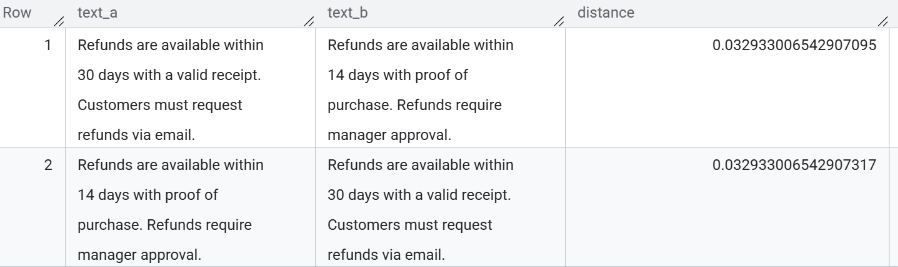

Uses ML.DISTANCE and a per-snippet top-K to keep it efficient on modest datasets.

**Quick validation**

In [ ]:
# Basic counts + distance range
SELECT COUNT(*) AS candidate_pairs,
       MIN(distance) AS best_sim,
       MAX(distance) AS worst_sim
FROM `.raw_policies.pair_candidates`;

# Preview the closest pairs
SELECT text_a, text_b, distance
FROM `.raw_policies.pair_candidates`
ORDER BY distance ASC
LIMIT 20;


**Output**

[{
  "candidate_pairs": "2",
  "best_sim": "0.032933006542907095",
  "worst_sim": "0.032933006542907317"
}]

2 candidate pairs were found (your two snippets compared both ways: A→B and B→A).
Cosine distances ~0.033 → very small → strong semantic similarity (they’re basically “about the same thing” but with some differences).

**AI comparison**
1) Take those candidate pairs from pair_candidates.

2) Call AI.GENERATE (in BigQuery) with a JSON schema.

3) Get a structured output:

    * change_type (NoChange, BehavioralChange, Contradiction, etc.)

    * summary of the difference

    * recommended_unified_clause

    * confidence

In [ ]:
# Step 1: Create a table to store AI-generated comparisons between snippet pairs
# - Table: raw_policies.pair_comparisons
CREATE OR REPLACE TABLE `.raw_policies.pair_comparisons` AS

# Step 2: Select pairs of clauses from the candidate table
SELECT
  text_a,         # Original snippet
  text_b,         # Candidate neighbor snippet
  distance,       # Cosine distance between embeddings

  # Step 3: Use AI.GENERATE to analyze differences between the two snippets
  AI.GENERATE(
    (
      '<<ONLY_RETURN_VALID_JSON>> ' ||                               # Force strict JSON-only response
      'Return a JSON object with ALL of the following fields:' ||
      ' { "change_type": STRING, "summary": STRING, "recommended_unified_clause": STRING, "confidence": FLOAT64 } ' ||

      # Rules to ensure consistent and parseable outputs
      'STRICT RULES:' ||
      ' - Always include ALL 4 fields (no omissions).' ||
      ' - "change_type" must be one of ["NoChange","MinorReword","BehavioralChange","Removed","Added","Contradiction"].' ||
      ' - "summary" must be a short explanation (<= 50 words).' ||
      ' - "recommended_unified_clause" must be a 1–2 sentence unified refund clause (do not leave blank).' ||
      ' - "confidence" must be a numeric decimal between 0 and 1 (e.g., 0.87), never text.' ||
      ' - Do not include explanations or text outside the JSON object.' ||

      # Provide the old vs. new clauses as context
      'OLD clause: ' || text_a || ' NEW clause: ' || text_b
    ),

    # Step 4: Required settings for BigQuery AI
    connection_id => 'connection_id',     # 🔹 Replace with your BigQuery connection name
    endpoint => 'gemini-2.5-flash',       # Gemini model endpoint for text generation

    # Step 5: Enforce output schema (ensures parseable structured output)
    output_schema => '''
      change_type STRING,
      summary STRING,
      recommended_unified_clause STRING,
      confidence FLOAT64
    '''
  ) AS verdict

# Step 6: Limit for demo/testing (remove for full run)
FROM `.raw_policies.pair_candidates`
LIMIT 50;

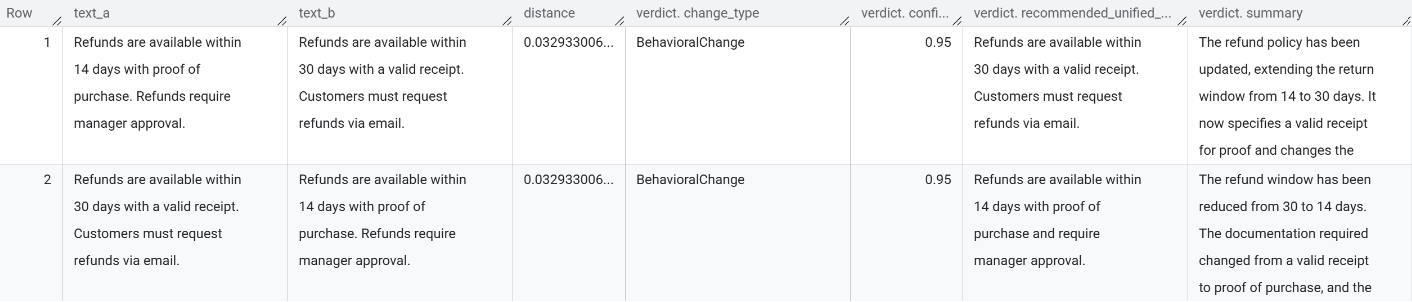

**Human in the loop**

At this stage, the AI verdicts are not blindly trusted.
A reviewer (policy analyst, compliance officer, etc.) looks at:

* change_type

* summary

* recommended_unified_clause

* confidence

and decides whether to approve or reject the AI’s proposal.

In [ ]:
# Step 1: Add a new column to track manual/automatic review decisions
ALTER TABLE `.raw_policies.pair_comparisons`
ADD COLUMN review_status STRING;

# Step 2: Update rows that meet approval criteria
UPDATE `.raw_policies.pair_comparisons`
SET review_status = 'APPROVED'
WHERE verdict.change_type = 'BehavioralChange'   # Only approve if model detected a behavioral change
  AND verdict.confidence > 0.9                   # Ensure model confidence is high (>90%)
  AND text_a LIKE '%refund%';                    # Restrict to refund-related clauses only


**Canonical KB Update**

In [ ]:
# Step 1: Create or replace the canonical refund policy table
CREATE OR REPLACE TABLE `idyllic-unity-470707-a5.demo_kd_kb_asia.refund_policy_canonical` AS
SELECT
  CURRENT_TIMESTAMP() AS approved_at,         # Timestamp when record was approved
  text_a,                                     # Original clause A
  text_b,                                     # Original clause B
  verdict.recommended_unified_clause AS unified_clause,  # AI-suggested reconciled clause
  verdict.change_type,                        # Type of detected change (BehavioralChange, etc.)
  verdict.confidence                          # AI confidence score
FROM `idyllic-unity-470707-a5.raw_policies.pair_comparisons`
WHERE review_status = 'APPROVED';             # Only include rows that passed human/auto review


* Approved recommendation is inserted into your knowledge base as the reconciled, authoritative clause.
* The canonical KB now contains the unified clause.
* Human reviewers can see the source snippets and the AI’s recommendation.
* All changes are auditable and linked to the original snippets.


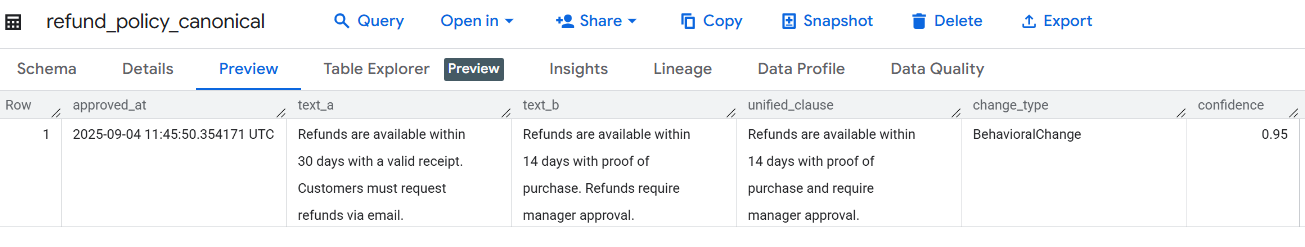

**Conclusion**

In this project, we successfully built a PolicyAlign: AI-Powered Drift Detection & Canonical Knowledge Builder using BigQuery AI. Starting with raw policy documents in Cloud Storage, we extracted clause-level snippets, generated embeddings, and compared old vs. new clauses to identify policy changes.

Through the use of AI.GENERATE, we classified differences into meaningful categories (e.g., BehavioralChange, Contradiction), produced concise summaries, suggested unified canonical clauses, and assigned confidence scores. A human-in-the-loop review step ensured reliability and governance before final updates were written into the canonical knowledge base.

This end-to-end pipeline demonstrates how BigQuery’s native Generative AI and Vector Search can be combined to:

* Detect semantic drift in unstructured documents.

* Provide actionable recommendations instead of raw differences.

* Maintain a continuously updated, authoritative knowledge base.

**Key Takeaways**

* Scalability: Entire pipeline runs within BigQuery, handling large-scale documents efficiently.

* Accuracy: Semantic embeddings and strict JSON schemas ensure consistent and interpretable AI outputs.

* Governance: Human review and confidence thresholds safeguard business-critical policy updates.

**Extensibility**: The same framework can be applied to contracts, compliance docs, legal updates, or image-based multimodal policies in the future.

🚀 With this workflow, organizations can stay ahead of knowledge drift, reduce manual review efforts, and maintain a single source of truth for evolving policies.